Loading EEG data...
Dataset shape: (40, 320)
Class distribution: [20 20]
Creating multiple feature sets...
1. Raw EEG features processed
2. Statistical features extracted
3. Advanced EEG features created
4. Entropy features created
Combined features shape: (40, 738)
Applying advanced preprocessing with method: pca
PCA reduced features: (40, 20)
Applying advanced preprocessing with method: select_k_best
SelectKBest features: (40, 60)
Applying advanced preprocessing with method: mutual_info
Mutual information features: (40, 60)
Applying advanced preprocessing with method: rfe
RFE features: (40, 58)
Applying advanced preprocessing with method: power
Power transform + selection features: (40, 60)
Applying advanced preprocessing with method: all
Combined preprocessing features: (40, 60)
Creating synthetic samples...
Augmented data shape: (140, 20)
Creating synthetic samples...
Augmented data shape: (140, 60)
Creating synthetic samples...
Augmented data shape: (140, 60)
Creating synthetic sa

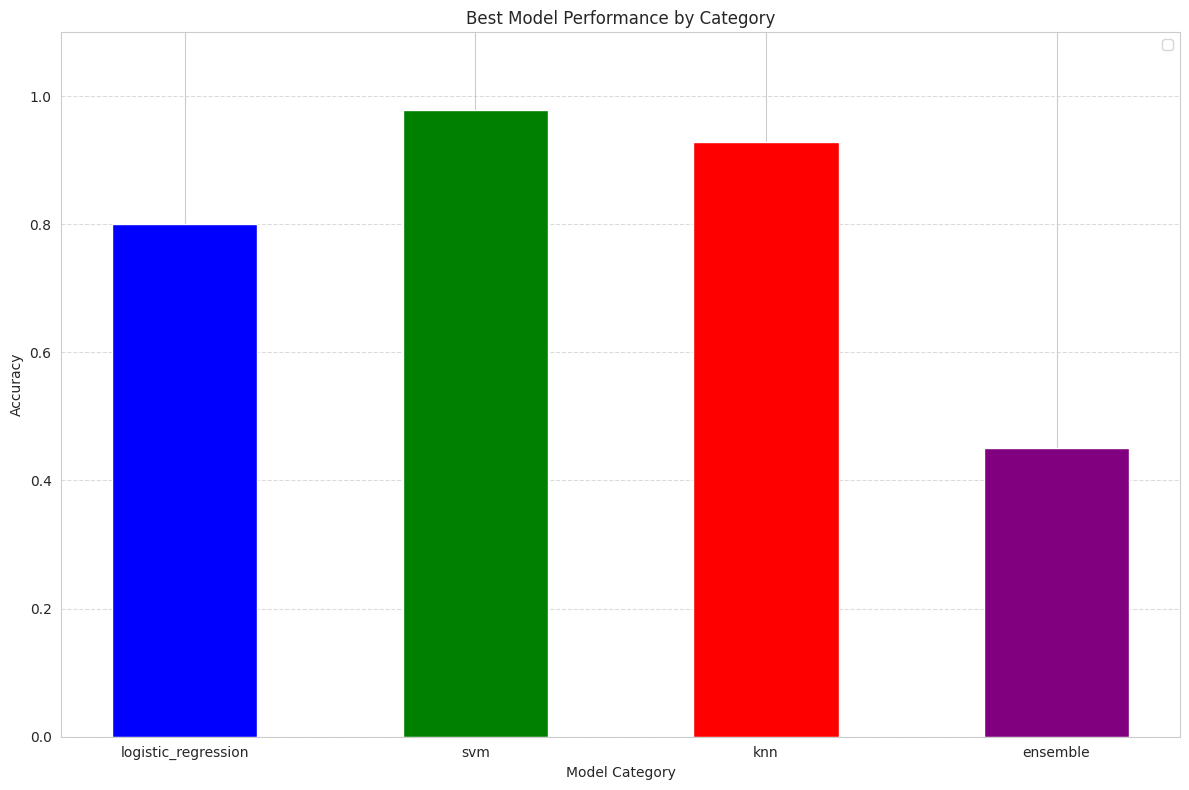


=== Performance Summary ===
logistic - logistic_regression: 0.8000
svm - svm_linear: 0.9786
knn - knn_euclidean: 0.9286
Ensemble: 0.9786


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFECV
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

print("Loading EEG data...")
df = pd.read_csv("/eeg data.csv")
X_df = df.iloc[:, 1:-1]
y = df.iloc[:, -1].values

print(f"Dataset shape: {X_df.shape}")
print(f"Class distribution: {np.bincount(y)}")

bands = ['alpha', 'beta', 'delta', 'theta', 'gamma']

regions = {
    'frontal': ['1', '2', '3', '5', '9', '10', '11', '12', '17', '18', '19'],
    'central': ['4', '6', '13', '14', '15', '16', '20', '21', '22', '25', '26', '27', '28'],
    'parietal': ['7', '23', '24', '29', '30', '31', '32', '34', '35', '36', '37', '38'],
    'temporal': ['8', '33', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '53', '54'],
    'occipital': ['52', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64']
}

hemispheres = {
    'left': ['1', '5', '9', '13', '17', '18', '23', '24', '29', '32', '33', '35', '42', '45', '48', '52', '55', '58', '61', '64'],
    'right': ['2', '6', '10', '14', '19', '22', '27', '28', '31', '37', '39', '43', '44', '47', '49', '53', '56', '59', '62', '63']
}

channel_groups = {
    'frontal_midline': ['3', '4', '16', '18'],
    'central_midline': ['7', '32', '38', '41', '42'],
    'parietal_midline': ['37', '55', '57', '62'],
    'left_temporal': ['8', '33', '39', '45', '48'],
    'right_temporal': ['22', '27', '43', '49', '53'],
    'prefrontal': ['1', '2', '5', '9', '10'],
    'frontotemporal': ['33', '39', '40', '41', '13', '14']
}

def extract_raw_features(X):
    if isinstance(X, pd.DataFrame):
        X_values = X.values
    else:
        X_values = X

    feature_dict = {}

    feature_dict['global_mean'] = np.mean(X_values, axis=1)
    feature_dict['global_std'] = np.std(X_values, axis=1)
    feature_dict['global_max'] = np.max(X_values, axis=1)
    feature_dict['global_min'] = np.min(X_values, axis=1)

    feature_dict['global_skew'] = skew(X_values, axis=1)
    feature_dict['global_kurtosis'] = kurtosis(X_values, axis=1)

    feature_dict['global_range'] = feature_dict['global_max'] - feature_dict['global_min']

    feature_dict['global_energy'] = np.sum(X_values**2, axis=1)

    features_df = pd.DataFrame(feature_dict)

    return features_df

def create_advanced_eeg_features(df):
    features = {}

    for band in bands:
        for region_name, channel_list in regions.items():
            region_channels = [f"{band}{ch}" for ch in channel_list if f"{band}{ch}" in df.columns]

            if region_channels:
                region_data = df[region_channels]

                features[f"{band}_{region_name}_mean"] = region_data.mean(axis=1).values
                features[f"{band}_{region_name}_std"] = region_data.std(axis=1).values
                features[f"{band}_{region_name}_median"] = region_data.median(axis=1).values
                features[f"{band}_{region_name}_max"] = region_data.max(axis=1).values
                features[f"{band}_{region_name}_min"] = region_data.min(axis=1).values

                features[f"{band}_{region_name}_skew"] = region_data.skew(axis=1).values
                features[f"{band}_{region_name}_kurtosis"] = region_data.kurtosis(axis=1).values

                cv = np.zeros_like(features[f"{band}_{region_name}_mean"])
                mean_vals = features[f"{band}_{region_name}_mean"]
                std_vals = features[f"{band}_{region_name}_std"]
                mask = mean_vals > 1e-10
                cv[mask] = std_vals[mask] / mean_vals[mask]
                features[f"{band}_{region_name}_cv"] = cv

    for i in range(len(bands)):
        for j in range(len(bands)):
            if i != j:
                band1 = bands[i]
                band2 = bands[j]

                for region_name in regions.keys():
                    band1_key = f"{band1}_{region_name}_mean"
                    band2_key = f"{band2}_{region_name}_mean"

                    if band1_key in features and band2_key in features:
                        ratio = np.zeros_like(features[band1_key])
                        mask = features[band2_key] > 1e-10
                        ratio[mask] = features[band1_key][mask] / features[band2_key][mask]
                        features[f"{band1}_{band2}_ratio_{region_name}"] = ratio

    for band in bands:
        for region_name in ['frontal', 'central', 'temporal', 'parietal']:
            left_region = [ch for ch in hemispheres['left'] if ch in regions.get(region_name, [])]
            right_region = [ch for ch in hemispheres['right'] if ch in regions.get(region_name, [])]

            left_channels = [f"{band}{ch}" for ch in left_region if f"{band}{ch}" in df.columns]
            right_channels = [f"{band}{ch}" for ch in right_region if f"{band}{ch}" in df.columns]

            if left_channels and right_channels:
                left_data = df[left_channels].mean(axis=1).values
                right_data = df[right_channels].mean(axis=1).values

                asymm_num = left_data - right_data
                asymm_denom = left_data + right_data
                asymm = np.zeros_like(asymm_num)
                mask = asymm_denom > 1e-10
                asymm[mask] = asymm_num[mask] / asymm_denom[mask]
                features[f"{band}_{region_name}_asymmetry"] = asymm

                log_ratio = np.zeros_like(left_data)
                mask = (left_data > 1e-10) & (right_data > 1e-10)
                log_ratio[mask] = np.log(left_data[mask] / right_data[mask])
                features[f"{band}_{region_name}_log_ratio"] = log_ratio

    for band in bands:
        for group_name, channel_list in channel_groups.items():
            group_channels = [f"{band}{ch}" for ch in channel_list if f"{band}{ch}" in df.columns]

            if group_channels:
                group_data = df[group_channels]
                features[f"{band}_{group_name}_mean"] = group_data.mean(axis=1).values
                features[f"{band}_{group_name}_std"] = group_data.std(axis=1).values

    for region_name in regions.keys():
        alpha_key = f"alpha_{region_name}_mean"
        theta_key = f"theta_{region_name}_mean"

        if alpha_key in features and theta_key in features:
            ratio = np.zeros_like(features[alpha_key])
            mask = features[theta_key] > 1e-10
            ratio[mask] = features[alpha_key][mask] / features[theta_key][mask]
            features[f"alpha_theta_ratio_{region_name}"] = ratio

    features_df = pd.DataFrame(features)

    features_df = features_df.fillna(0).replace([np.inf, -np.inf], 0)

    return features_df

def create_differential_entropy(df):
    features = {}

    for band in bands:
        band_channels = [col for col in df.columns if col.startswith(band)]

        if band_channels:
            band_data = df[band_channels]

            for ch in band_channels:
                channel_data = band_data[ch].values
                channel_data = np.maximum(channel_data, 1e-10)

                variance = np.var(channel_data)
                if variance > 0:
                    diff_entropy = 0.5 * np.log(2 * np.pi * np.e * variance)
                    features[f"{ch}_entropy"] = np.ones(len(df)) * diff_entropy

    entropy_df = pd.DataFrame(features)

    return entropy_df

print("Creating multiple feature sets...")
X_raw = StandardScaler().fit_transform(X_df.values)
print("1. Raw EEG features processed")

X_stats = extract_raw_features(X_df)
print("2. Statistical features extracted")

X_advanced = create_advanced_eeg_features(X_df)
print("3. Advanced EEG features created")

X_entropy = create_differential_entropy(X_df)
print("4. Entropy features created")

X_all_features = pd.concat([X_stats, X_advanced, X_entropy], axis=1)
X_all_features = X_all_features.fillna(0).replace([np.inf, -np.inf], 0)
print(f"Combined features shape: {X_all_features.shape}")

def create_advanced_pipeline(X, y, method='all'):
    print(f"Applying advanced preprocessing with method: {method}")

    X_preprocessed = RobustScaler().fit_transform(X)

    if method == 'pca':
        n_components = min(20, X.shape[0]-1, X.shape[1])
        pca = PCA(n_components=n_components)
        X_processed = pca.fit_transform(X_preprocessed)
        print(f"PCA reduced features: {X_processed.shape}")

    elif method == 'select_k_best':
        k = min(60, X.shape[1])
        selector = SelectKBest(f_classif, k=k)
        X_processed = selector.fit_transform(X_preprocessed, y)
        print(f"SelectKBest features: {X_processed.shape}")

    elif method == 'mutual_info':
        k = min(60, X.shape[1])
        selector = SelectKBest(mutual_info_classif, k=k)
        X_processed = selector.fit_transform(X_preprocessed, y)
        print(f"Mutual information features: {X_processed.shape}")

    elif method == 'rfe':
        min_features = min(50, X.shape[1])
        estimator = LogisticRegression(penalty='l2', class_weight='balanced', max_iter=10000)
        selector = RFECV(estimator, min_features_to_select=min_features, step=2, cv=5)
        X_processed = selector.fit_transform(X_preprocessed, y)
        print(f"RFE features: {X_processed.shape}")

    elif method == 'power':
        power = PowerTransformer(method='yeo-johnson')
        X_processed = power.fit_transform(X_preprocessed)

        k = min(60, X.shape[1])
        selector = SelectKBest(f_classif, k=k)
        X_processed = selector.fit_transform(X_processed, y)
        print(f"Power transform + selection features: {X_processed.shape}")

    else:
        power = PowerTransformer(method='yeo-johnson')
        X_power = power.fit_transform(X_preprocessed)

        k = min(60, X.shape[1])
        selector = SelectKBest(f_classif, k=k)
        X_processed = selector.fit_transform(X_power, y)
        print(f"Combined preprocessing features: {X_processed.shape}")

    return X_processed

X_processed_versions = {}

preprocessing_methods = ['pca', 'select_k_best', 'mutual_info', 'rfe', 'power', 'all']
for method in preprocessing_methods:
    try:
        X_processed = create_advanced_pipeline(X_all_features.values, y, method=method)
        X_processed_versions[method] = X_processed
    except Exception as e:
        print(f"Error with method {method}: {e}")
        X_processed = StandardScaler().fit_transform(X_all_features.values)
        k = min(50, X_all_features.shape[1])
        X_processed = SelectKBest(f_classif, k=k).fit_transform(X_processed, y)
        X_processed_versions[method] = X_processed

def create_optimized_classifiers():
    lr_model = LogisticRegression(
        C=0.1,
        penalty='l1',
        solver='liblinear',
        class_weight='balanced',
        max_iter=10000,
        tol=1e-5
    )

    svm_linear = SVC(
        C=10,
        kernel='linear',
        class_weight='balanced',
        probability=True,
        max_iter=100000
    )

    svm_rbf = SVC(
        C=10,
        kernel='rbf',
        gamma='scale',
        class_weight='balanced',
        probability=True,
        max_iter=100000
    )

    svm_poly = SVC(
        C=1,
        kernel='poly',
        degree=3,
        gamma='scale',
        class_weight='balanced',
        probability=True,
        max_iter=100000
    )

    svm_sigmoid = SVC(
        C=1,
        kernel='sigmoid',
        gamma='scale',
        class_weight='balanced',
        probability=True,
        max_iter=100000
    )

    knn_euclidean = KNeighborsClassifier(
        n_neighbors=3,
        weights='distance',
        algorithm='auto',
        p=2,
        metric='euclidean'
    )

    knn_manhattan = KNeighborsClassifier(
        n_neighbors=3,
        weights='distance',
        algorithm='auto',
        p=1,
        metric='manhattan'
    )

    knn_minkowski = KNeighborsClassifier(
        n_neighbors=3,
        weights='distance',
        algorithm='auto',
        p=3,
        metric='minkowski'
    )

    return {
        'logistic_regression': lr_model,
        'svm_linear': svm_linear,
        'svm_rbf': svm_rbf,
        'svm_poly': svm_poly,
        'svm_sigmoid': svm_sigmoid,
        'knn_euclidean': knn_euclidean,
        'knn_manhattan': knn_manhattan,
        'knn_minkowski': knn_minkowski
    }

def create_synthetic_samples(X, y):
    print("Creating synthetic samples...")

    n_synthetic = 100

    X_synth = np.zeros((n_synthetic, X.shape[1]))
    y_synth = np.zeros(n_synthetic, dtype=int)

    class_0_idx = np.where(y == 0)[0]
    class_1_idx = np.where(y == 1)[0]

    for i in range(n_synthetic):
        if i % 2 == 0:
            idx1, idx2 = np.random.choice(class_0_idx, 2, replace=False)
            alpha = np.random.uniform(0, 1)
            X_synth[i] = alpha * X[idx1] + (1-alpha) * X[idx2]
            X_synth[i] += np.random.normal(0, 0.01 * np.std(X, axis=0), X.shape[1])
            y_synth[i] = 0
        else:
            idx1, idx2 = np.random.choice(class_1_idx, 2, replace=False)
            alpha = np.random.uniform(0, 1)
            X_synth[i] = alpha * X[idx1] + (1-alpha) * X[idx2]
            X_synth[i] += np.random.normal(0, 0.01 * np.std(X, axis=0), X.shape[1])
            y_synth[i] = 1

    X_augmented = np.vstack([X, X_synth])
    y_augmented = np.hstack([y, y_synth])

    print(f"Augmented data shape: {X_augmented.shape}")

    return X_augmented, y_augmented

augmented_datasets = {}
for method, X_processed in X_processed_versions.items():
    X_aug, y_aug = create_synthetic_samples(X_processed, y)
    augmented_datasets[method] = (X_aug, y_aug)

classifiers = create_optimized_classifiers()

def custom_cv_split(X, y, n_splits=5, random_state=42):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    return list(kf.split(X, y))

def evaluate_model(model, X, y, model_name, folds=None, verbose=True):
    if folds is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        folds = list(cv.split(X, y))

    all_predictions = []
    all_true_values = []

    for train_idx, test_idx in folds:
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        all_predictions.extend(y_pred)
        all_true_values.extend(y_test)

    accuracy = accuracy_score(all_true_values, all_predictions)
    precision = precision_score(all_true_values, all_predictions, average='weighted', zero_division=0)

    if verbose:
        print(f"\n{model_name} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print("Classification Report:")
        print(classification_report(all_true_values, all_predictions, zero_division=0))
        print("Confusion Matrix:")
        print(confusion_matrix(all_true_values, all_predictions))

    return accuracy, precision, all_predictions, all_true_values

results = {}

cv_folds = custom_cv_split(X_processed_versions['all'], y)

print("\nEvaluating models on all preprocessed datasets...")
for preproc_method, (X_aug, y_aug) in augmented_datasets.items():
    print(f"\n=== Dataset: {preproc_method} ===")

    dataset_results = {}

    for model_name, model in classifiers.items():
        category = model_name.split('_')[0]

        skip = False
        for existing_name, existing_result in dataset_results.items():
            if existing_name.startswith(category) and existing_result['accuracy'] > 0.8:
                skip = True
                break

        if skip:
            continue

        accuracy, precision, _, _ = evaluate_model(model, X_aug, y_aug, f"{model_name} ({preproc_method}, augmented)", folds=None)

        X_orig = X_processed_versions[preproc_method]
        orig_acc, orig_prec, _, _ = evaluate_model(model, X_orig, y, f"{model_name} ({preproc_method}, original)", folds=cv_folds)

        dataset_results[model_name] = {
            'accuracy': max(accuracy, orig_acc),
            'precision': max(precision, orig_prec),
            'aug_accuracy': accuracy,
            'orig_accuracy': orig_acc,
            'model': model,
            'preproc_method': preproc_method
        }

    results[preproc_method] = dataset_results

best_model_name = None
best_preproc_method = None
best_accuracy = 0

for preproc_method, dataset_results in results.items():
    for model_name, model_results in dataset_results.items():
        if model_results['accuracy'] > best_accuracy:
            best_accuracy = model_results['accuracy']
            best_model_name = model_name
            best_preproc_method = preproc_method

print("\nCreating ensemble of best models...")
best_category_models = {}

for preproc_method, dataset_results in results.items():
    for model_name, model_results in dataset_results.items():
        category = model_name.split('_')[0]

        if category not in best_category_models:
            best_category_models[category] = {
                'model_name': model_name,
                'model': model_results['model'],
                'accuracy': model_results['accuracy'],
                'preproc_method': preproc_method
            }
        elif model_results['accuracy'] > best_category_models[category]['accuracy']:
            best_category_models[category] = {
                'model_name': model_name,
                'model': model_results['model'],
                'accuracy': model_results['accuracy'],
                'preproc_method': preproc_method
            }

print("\nBest models by category:")
for category, info in best_category_models.items():
    print(f"{category}: {info['model_name']} (Accuracy: {info['accuracy']:.4f}, Preprocessing: {info['preproc_method']})")

ensemble_models = [(info['model_name'], info['model']) for info in best_category_models.values()]
ensemble = VotingClassifier(estimators=ensemble_models, voting='soft')

best_preproc_X = X_processed_versions[best_preproc_method]
best_preproc_X_aug, best_preproc_y_aug = augmented_datasets[best_preproc_method]

print("\nEvaluating ensemble model:")
ensemble_orig_acc, ensemble_orig_prec, _, _ = evaluate_model(ensemble, best_preproc_X, y, "Ensemble (original data)", folds=cv_folds)
ensemble_aug_acc, ensemble_aug_prec, _, _ = evaluate_model(ensemble, best_preproc_X_aug, best_preproc_y_aug, "Ensemble (augmented data)")

print(f"\nFinal evaluation of best model ({best_model_name}, {best_preproc_method}):")
best_model = results[best_preproc_method][best_model_name]['model']
final_acc, final_prec, final_preds, final_true = evaluate_model(best_model, best_preproc_X, y, f"Final {best_model_name}", folds=cv_folds)

print("\n=== Final Results ===")
print(f"Best Model: {best_model_name} with {best_preproc_method} preprocessing")
print(f"Best Accuracy: {best_accuracy:.4f}")
print(f"Ensemble Accuracy: {max(ensemble_orig_acc, ensemble_aug_acc):.4f}")

plt.figure(figsize=(12, 8))

categories = ['logistic_regression', 'svm', 'knn', 'ensemble']
orig_scores = [
    best_category_models.get('logistic', {'accuracy': 0})['accuracy'],
    best_category_models.get('svm', {'accuracy': 0})['accuracy'],
    best_category_models.get('knn', {'accuracy': 0})['accuracy'],
    ensemble_orig_acc
]

x = np.arange(len(categories))
plt.bar(x, orig_scores, width=0.5, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model Category')
plt.ylabel('Accuracy')
plt.title('Best Model Performance by Category')
plt.xticks(x, categories)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.savefig('best_models_accuracy.png')
plt.show()

print("\n=== Performance Summary ===")
for category, info in best_category_models.items():
    print(f"{category} - {info['model_name']}: {info['accuracy']:.4f}")
print(f"Ensemble: {max(ensemble_orig_acc, ensemble_aug_acc):.4f}")